We import all the required library. Numpy, Pandas, sklearn and matplotlib

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas.plotting import parallel_coordinates
from sklearn.metrics import silhouette_score
from sklearn import metrics


The dataset is a collection of all players data from 2015-2017 from all the 30 teams. 

In [22]:
alldata = pd.read_csv('/Users/mac/Desktop/my work/baseball case/downloads folder data/Undersampling_15-17_Classification.csv',low_memory=False)
print("The shape of the dataframe is: ",pd.DataFrame(alldata).shape)
required=['player_name','p_throws','pitch_type','Arctan_direction','launch_angle','zone','hit_distance_sc','launch_speed','release_speed','momentum','Outcome']
df = pd.DataFrame(alldata, columns=required)
df.head()

The shape of the dataframe is:  (253180, 43)


,player_name,p_throws,pitch_type,Arctan_direction,launch_angle,zone,hit_distance_sc,launch_speed,release_speed,momentum,Outcome
0,JaCoby Jones,R,FT,-2.1,18.209,1,208,83,92.6,75.1396129,SINGLE
1,Bryan Holaday,R,FT,9.8,2.860,5,86,101.1,92.1,86.9996129,SINGLE
2,Efren Navarro,L,SI,-19,2.457,8,94,105.7,91.3,89.86658065,SINGLE
3,Bryan Holaday,R,FF,-30.8,17.460,11,268,91.7,89.6,80.23670968,DOUBLE
4,Alex Presley,R,FF,32.9,36.985,6,352,97.6,87.9,83.76651613,HR


Handling missing data:
Since the number of missing value are limited to only one column and there are very less values,
we drop the rows with missing values.

In [23]:
print("Before\n",df.isnull().sum())
df=df.dropna()
print("After\n",df.isnull().sum())

Before
 player_name           0
p_throws              0
pitch_type          183
Arctan_direction      0
launch_angle          0
zone                  0
hit_distance_sc       0
launch_speed          0
release_speed         0
momentum              0
Outcome               0
dtype: int64
After
 player_name         0
p_throws            0
pitch_type          0
Arctan_direction    0
launch_angle        0
zone                0
hit_distance_sc     0
launch_speed        0
release_speed       0
momentum            0
Outcome             0
dtype: int64


There are many "null" values in the dataset. "null" values doesnt have any outcomes. 
so we remove rows in which there are "null" values. In this dataset there are many columns which has "null" values.
To find the columns which has "null" values we run a for loop. 
Arctan_direction column has value '#DIV/0!' in few rows. So we remove that as well.

In [24]:
colum_contains_null=[]
for i in df.columns:
    if('null'  in set(df[i])):
        colum_contains_null.append(i)

print("Columns which contains 'null'",colum_contains_null)

Columns which contains 'null' ['pitch_type', 'zone', 'hit_distance_sc', 'launch_speed', 'release_speed']


In [25]:
df=df[df.pitch_type !='null']
df=df[df.zone !='null']
df=df[df.hit_distance_sc !='null']
df=df[df.launch_speed !='null']
df=df[df.release_speed !='null']
# df=df[df.effective_speed !=' ']
df=df[df.Arctan_direction !='#DIV/0!']
df.head()

,player_name,p_throws,pitch_type,Arctan_direction,launch_angle,zone,hit_distance_sc,launch_speed,release_speed,momentum,Outcome
0,JaCoby Jones,R,FT,-2.1,18.209,1,208,83,92.6,75.1396129,SINGLE
1,Bryan Holaday,R,FT,9.8,2.860,5,86,101.1,92.1,86.9996129,SINGLE
2,Efren Navarro,L,SI,-19,2.457,8,94,105.7,91.3,89.86658065,SINGLE
3,Bryan Holaday,R,FF,-30.8,17.460,11,268,91.7,89.6,80.23670968,DOUBLE
4,Alex Presley,R,FF,32.9,36.985,6,352,97.6,87.9,83.76651613,HR


In [26]:
print(df.dtypes)
print(df.shape)
# df.effective_speed.value_counts()

player_name          object
p_throws             object
pitch_type           object
Arctan_direction     object
launch_angle        float64
zone                 object
hit_distance_sc      object
launch_speed         object
release_speed        object
momentum             object
Outcome              object
dtype: object
(225350, 11)


We convert the numerical columns from object to float64. 
We convert pitch_type, p_throws,zone and outcome to categorical.


In [27]:
df[['hit_distance_sc','launch_speed','release_speed','momentum','Arctan_direction']] = df[['hit_distance_sc','launch_speed','release_speed','momentum','Arctan_direction']].astype('float')
df['pitch_type']=df['pitch_type'].astype('category')
df['p_throws']=df['p_throws'].astype('category')
df['Outcome']=df['Outcome'].astype('category')
df['zone']=df['zone'].astype('category')
print(df.dtypes)
print(df.head())

player_name           object
p_throws            category
pitch_type          category
Arctan_direction     float64
launch_angle         float64
zone                category
hit_distance_sc      float64
launch_speed         float64
release_speed        float64
momentum             float64
Outcome             category
dtype: object
     player_name p_throws pitch_type  Arctan_direction  launch_angle zone  \
0   JaCoby Jones        R         FT              -2.1        18.209    1   
1  Bryan Holaday        R         FT               9.8         2.860    5   
2  Efren Navarro        L         SI             -19.0         2.457    8   
3  Bryan Holaday        R         FF             -30.8        17.460   11   
4   Alex Presley        R         FF              32.9        36.985    6   

   hit_distance_sc  launch_speed  release_speed   momentum Outcome  
0            208.0          83.0           92.6  75.139613  SINGLE  
1             86.0         101.1           92.1  86.999613  SINGLE

Our approach is to identiy 30 players who have higher performance ranking and who are similar to Jackie Bradley Jr. 
We used physical attributes like speed, momentum etc and used euclidean distance measure 
to find arrive at a recommendation for Jackie Bradley Jr.

In [28]:
recomend=pd.read_excel('/Users/mac/Downloads/book1.xlsx')

recomend.head()


,Names
0,Brandon Nimmo
1,Tim Beckham
2,Scooter Gennett
3,Michael Taylor
4,Corey Dickerson


Select the rows only for the players who are present in the recommendation list above.

In [29]:
r_list=[]
for i in recomend['Names']:
    r_list.append(i)

df=df[df['player_name'].isin(r_list)]

print("The final dataset shape is",df.shape)

The final dataset shape is (14689, 11)


Prepare the final dataset by having a separate data for input and output. We remove player_name from the dataset.

In [30]:
features = df.columns[:10]
# View features
df['Outcome']=df['Outcome'].replace('OUt', 'Out')
print(set(df['Outcome']))
x=df[features]
x=x.drop('player_name',1)
print(x.columns)
y=df['Outcome']
#print(set(y))
#y=y.astype('category')

{'SINGLE', 'Out', 'TRIPLE', 'HR', 'DOUBLE'}
Index(['p_throws', 'pitch_type', 'Arctan_direction', 'launch_angle', 'zone',
       'hit_distance_sc', 'launch_speed', 'release_speed', 'momentum'],
      dtype='object')


Convert categorical variables into numerical by using get dummies methodology.  
Since the machine learning algorithms work with numerical features, its
necessary to convery the categorical variables into numerical.There are many ways to do it. 
The simplest of them is by assingning dummy variable to all possible categories in the feature.

In [31]:
#get dummies for Pitch_type
temp1=pd.get_dummies(x['pitch_type'],drop_first=True)
temp1.head()
x=pd.concat([x,temp1],axis=1)
x=x.drop('pitch_type',1)
print(x.head())
# print(y.head())

   p_throws  Arctan_direction  launch_angle zone  hit_distance_sc  \
10        R              30.8        28.523    8            148.0   
14        R              18.5        33.162   12            225.0   
27        L              24.9        11.516    6            213.0   
32        R             -35.3        19.792    8            173.0   
88        R             -29.5        -2.382    8             27.0   

    launch_speed  release_speed   momentum  CU  EP ...  FO  FS  FT  KC  KN  \
10          57.9           81.0  56.004194   0   0 ...   0   0   0   0   0   
14          68.0           92.2  65.132774   0   0 ...   0   0   0   0   0   
27          91.3           92.8  80.672065   0   0 ...   0   0   0   0   0   
32          70.2           86.0  65.231613   0   0 ...   0   0   0   0   0   
88          91.8           91.4  80.696516   0   0 ...   0   0   0   0   0   

    PO  SC  SI  SL  UN  
10   0   0   0   1   0  
14   0   0   0   0   0  
27   0   0   0   0   0  
32   0   0   0  

In [32]:
#get dummies for P_throws
temp2=pd.get_dummies(x['p_throws'],drop_first=True)
temp2.head()
x=pd.concat([x,temp2],axis=1)
x=x.drop('p_throws',1)
print(x.head())
# print(y.head())

    Arctan_direction  launch_angle zone  hit_distance_sc  launch_speed  \
10              30.8        28.523    8            148.0          57.9   
14              18.5        33.162   12            225.0          68.0   
27              24.9        11.516    6            213.0          91.3   
32             -35.3        19.792    8            173.0          70.2   
88             -29.5        -2.382    8             27.0          91.8   

    release_speed   momentum  CU  EP  FA ...  FS  FT  KC  KN  PO  SC  SI  SL  \
10           81.0  56.004194   0   0   0 ...   0   0   0   0   0   0   0   1   
14           92.2  65.132774   0   0   0 ...   0   0   0   0   0   0   0   0   
27           92.8  80.672065   0   0   0 ...   0   0   0   0   0   0   0   0   
32           86.0  65.231613   0   0   0 ...   0   0   0   0   0   0   0   1   
88           91.4  80.696516   0   0   0 ...   0   0   0   0   0   0   0   0   

    UN  R  
10   0  1  
14   0  1  
27   0  0  
32   0  1  
88   0  1  

[

Create a training and test dataset using cross validation library. We have assigned 70% data to train and 30% to test. 

In [33]:
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

We start using various machine learning algorithms. 
Our aim to predict the outcome of the play wheter its Out, Single, Double, HR or Triple. 
We decide to use Majority voting, so we look for the 3 top algorithms which has an higher accuracy on the test data set.

In [34]:
#test random forest classifier
rforest=RandomForestClassifier()
rforest.fit(x_train,y_train)
y_pred=rforest.predict(x_test)
print('accuracy using random forest:',metrics.accuracy_score(y_test, y_pred))
# print(x_train.head())


accuracy using random forest: 0.712275924665


In [35]:
# test decision tree classifier
from sklearn import tree
clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(x_train, y_train)
dt_pred=clf_gini.predict(x_test)
print('accuracy using decision tree:',metrics.accuracy_score(y_test, dt_pred))


accuracy using decision tree: 0.632856818698


In [36]:
#KNN with N=6
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train,y_train)
knn_pred=knn.predict(x_test)
print('accuracy using KNN with N=6:',metrics.accuracy_score(y_test, knn_pred))


accuracy using KNN with N=6: 0.725663716814


We use a range of values for KNN and decide which value we can choose. 
Using matplotlib pyplot we plot the accuracy for every N values. 
This gives a comprehensive picture of choosing one N value.

Text(0,0.5,'testing accuracy')

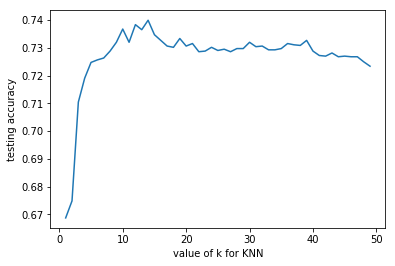

In [37]:
#KNN with range of N values
k_range=range(1,50)
scores=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    knn_pred=knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test,knn_pred))


import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_range,scores)
plt.xlabel("value of k for KNN")
plt.ylabel("testing accuracy")

Cross validation helps to determine the accuracy of the model on an unknow data.
We can validate if the KNN model performs well on an unknown dataset by using crossvalidation.
The Best KNN model performs even well on cross validation as seen by the increase in accuracy. 

In [38]:
#KNN with cross validation
from sklearn.cross_validation import cross_val_score

# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=18)
print(cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy').mean())

0.749466116477


Text(0,0.5,'testing accuracy')

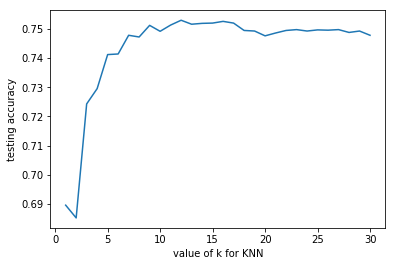

In [39]:
#KNN for multiple Neighbor values
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# import matplotlib.pyplot as plt
# %matplotlib inline
plt.plot(k_range,k_scores)
plt.xlabel("value of k for KNN")
plt.ylabel("testing accuracy")

Since we have a good accuracy in KNN we decided to check further and also do hyper parameter tunning using Grid search.
we try to vary the N and the weight option and look at the parameter which yields the best accuracy score.

In [42]:
#Grid search with KNN
from sklearn.grid_search import GridSearchCV
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(x_train, y_train)
grid_pred=grid.predict(x_test)

print("The Best score is ",grid.best_score_)
print("The best parameters that gives the best score is ",grid.best_params_)
print("The best estimator is ",grid.best_estimator_)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}
The Best score is  0.753355378331064
The best parameters that gives the best score is  {'n_neighbors': 25, 'weights': 'distance'}
The best estimator is  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='distance')


We try all the other algorithms to identify the model which gives the best score for this dataset.

In [46]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_predict=logreg.predict(x_test)
print('accuracy using Logistic Regression:',metrics.accuracy_score(y_test, logreg_predict))

#SVM
from sklearn import svm
svmcf = svm.SVC()
svmcf.fit(x_train, y_train)
svmcf.score(x_train, y_train)
#Predict Output
svm_pred= svmcf.predict(x_test)
print('accuracy for SVM is :',metrics.accuracy_score(y_test, svm_pred))


#Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
naivecf=GaussianNB()
naivecf.fit(x_train, y_train)
#Predict Output
naive_pred= naivecf.predict(x_test)
print('accuracy for Naive Bayes Classifier:',metrics.accuracy_score(y_test, naive_pred))

#Random forest
from sklearn.ensemble import RandomForestClassifier
rfcf= RandomForestClassifier()
# Train the model using the training sets and check score
rfcf.fit(x_train, y_train)
#Predict Output
rf_pred= rfcf.predict(x_test)
print('accuracy for Random forest is:',metrics.accuracy_score(y_test, rf_pred))




#GBM
from sklearn.ensemble import GradientBoostingClassifier
gbmcf= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbmcf.fit(x_train, y_train)
gbm_pred= gbmcf.predict(x_test)
print('accuracy for Gradient Boosting classifier:',metrics.accuracy_score(y_test, gbm_pred))







accuracy using Logistic Regression: 0.559564329476
accuracy for SVM is : 0.596550941684
accuracy for Naive Bayes Classifier: 0.428409348763
accuracy for Random forest is: 0.707737690039
accuracy for Gradient Boosting classifier: 0.749716360336


In [47]:
print("confusion matrix for the test and prediction\n",metrics.confusion_matrix(y_test, grid_pred))
print("\nRecall score is ",metrics.recall_score(y_test, grid_pred,average="weighted"))
# print("\nPrecision core is ",metrics.precision_score(y_test, grid_pred,average="weighted"))


# print(1 - metrics.accuracy_score(y_test, grid_pred))



confusion matrix for the test and prediction
 [[ 148   52  170  137    0]
 [   6  342   19    0    0]
 [  45   23 1623  355    0]
 [  23    1  307 1108    0]
 [  11    9   19    9    0]]

Recall score is  0.730882686635


In [ ]:
Load the test data. 
All the test data points are generated using probability distribution identified for inidividual features. 
We can simulate using probability distribution a huge number of datapoints. 
These represents entire pitches Jackie Bradley Jr. will encounter for 2018 season. 
We can have multiple simulations to analyze further. Here we only look at one simulation.

In [54]:
jbr_csv=pd.read_csv("/Users/mac/Desktop/my work/baseball case/downloads folder data/Test_dataV2.0.csv")
jbr=pd.DataFrame(jbr_csv)
jbr=jbr.drop('Outcome',1)
jbr=jbr.dropna()
print(" The data looks like", jbr.head())
print("\nThe dimension of the test data set is", jbr.shape)

 The data looks like   Name  Arctan_direction  launch_angle  zone  hit_distance_sc  Launch_speed  \
0  JBJ               -18           -76   5.0         1.220708            89   
1  JBJ               -12           -76   5.0         1.222213           103   
2  JBJ               -28           -76   5.0         1.222462           106   
3  JBJ                14           -75   5.0         1.309667            77   
4  JBJ               -27           -75   5.0         1.311520            87   

   release_speed    momentum pitch_type p_throws  
0      87.691887  138.486605         FT        R  
1      89.385032  153.749127         FF        L  
2      90.888336  157.634333         FF        R  
3      89.197856  126.998248         FF        L  
4     100.821293  143.512708         FF        L  

The dimension of the test data set is (10860, 10)


We convert the pitch_type and p_throws into category and then convert them into numberical using dummy encoding. 

In [55]:
#get dummies for Pitch_type & p_throws
jbr['pitch_type']=df['pitch_type'].astype('category')
jbr['p_throws']=jbr['p_throws'].astype('category')
jbr.dtypes

temp1_1=pd.get_dummies(jbr['pitch_type'],drop_first=True)
temp1_1.head()
jbr=pd.concat([jbr,temp1_1],axis=1)
jbr=jbr.drop('pitch_type',1)
# print(jbr.head())

temp1_1=pd.get_dummies(jbr['p_throws'],drop_first=True)
temp1_1.head()
jbr=pd.concat([jbr,temp1_1],axis=1)
jbr=jbr.drop('p_throws',1)
# print(jbr.head())
jbr=jbr.drop('Name',1)
print(jbr.head())

# print(y.head())

   Arctan_direction  launch_angle  zone  hit_distance_sc  Launch_speed  \
0               -18           -76   5.0         1.220708            89   
1               -12           -76   5.0         1.222213           103   
2               -28           -76   5.0         1.222462           106   
3                14           -75   5.0         1.309667            77   
4               -27           -75   5.0         1.311520            87   

   release_speed    momentum  CU  EP  FA ...  FS  FT  KC  KN  PO  SC  SI  SL  \
0      87.691887  138.486605   0   0   0 ...   0   0   0   0   0   0   0   0   
1      89.385032  153.749127   0   0   0 ...   0   0   0   0   0   0   0   0   
2      90.888336  157.634333   0   0   0 ...   0   0   0   0   0   0   0   0   
3      89.197856  126.998248   0   0   0 ...   0   0   0   0   0   0   0   0   
4     100.821293  143.512708   0   0   0 ...   0   0   0   0   0   0   0   0   

   UN  R  
0   0  1  
1   0  0  
2   0  1  
3   0  0  
4   0  0  

[5 rows

In [56]:

jbr[['hit_distance_sc','Launch_speed','launch_angle','release_speed','momentum','Arctan_direction']] = jbr[['hit_distance_sc','Launch_speed','launch_angle','release_speed','momentum','Arctan_direction']].astype('float')
jbr['zone']=jbr['zone'].astype('category')
print(jbr.dtypes)


Arctan_direction     float64
launch_angle         float64
zone                category
hit_distance_sc      float64
Launch_speed         float64
release_speed        float64
momentum             float64
CU                     uint8
EP                     uint8
FA                     uint8
FC                     uint8
FF                     uint8
FO                     uint8
FS                     uint8
FT                     uint8
KC                     uint8
KN                     uint8
PO                     uint8
SC                     uint8
SI                     uint8
SL                     uint8
UN                     uint8
R                      uint8
dtype: object


In [58]:
# get the best classifiers

#GBM
from sklearn.ensemble import GradientBoostingClassifier
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create Gradient Boosting Classifier object
gbm= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# Train the model using the training sets and check score
gbm.fit(x, y)
#Predict Output
gbm_pred= gbm.predict(jbr)
# print(gbm_pred.head())
gbm_prob=gbm.predict_proba(jbr)


#KNN

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21,weights='distance')
knn.fit(x,y)
knn_pred=knn.predict(jbr)
# print(knn_pred.head())
knn_prob=knn.predict_proba(jbr)



#RF


rf_pred= rfcf.predict(jbr)
rf_prob=rfcf.predict_proba(jbr)




In [59]:
knn_prob=knn.predict_proba(jbr)
print(len(knn_prob))
print(len(jbr))
print(knn_pred)

10860
10860
['Out' 'Out' 'Out' ..., 'HR' 'HR' 'HR']


In [60]:

# gets a dictionary of {'class_name': probability}
prob_per_class_dictionary = dict(zip(gbm.classes_, gbm_prob))
prob_per_class_array=list(zip(gbm.classes_, gbm_prob))
print(prob_per_class_dictionary)
print(prob_per_class_array)

# gets a list of ['most_probable_class', 'second_most_probable_class', ..., 'least_class']
# results_ordered_by_probability = map(lambda x: x[0], sorted(zip(model.classes_, results), key=lambda x: x[1], reverse=True))

{'DOUBLE': array([  8.90883759e-05,   3.78425359e-08,   9.77714918e-01,
         2.21887589e-02,   7.19667292e-06]), 'HR': array([  6.61848801e-04,   2.57614311e-08,   9.68497559e-01,
         3.08224271e-02,   1.81391395e-05]), 'Out': array([  4.36246075e-03,   5.60943453e-06,   9.54141564e-01,
         4.14571194e-02,   3.32468225e-05]), 'SINGLE': array([  1.00872170e-04,   2.37379164e-09,   9.89563303e-01,
         1.03255482e-02,   1.02745889e-05]), 'TRIPLE': array([  2.00099174e-04,   2.66894650e-07,   9.90853491e-01,
         8.94337316e-03,   2.76981790e-06])}
[('DOUBLE', array([  8.90883759e-05,   3.78425359e-08,   9.77714918e-01,
         2.21887589e-02,   7.19667292e-06])), ('HR', array([  6.61848801e-04,   2.57614311e-08,   9.68497559e-01,
         3.08224271e-02,   1.81391395e-05])), ('Out', array([  4.36246075e-03,   5.60943453e-06,   9.54141564e-01,
         4.14571194e-02,   3.32468225e-05])), ('SINGLE', array([  1.00872170e-04,   2.37379164e-09,   9.89563303e-01,
      

Load the output along with their corresponding probabilities into excel file. 
We use Majority voting on the output to arrive at the final output.

In [62]:
result_prob=pd.DataFrame(knn_prob)
result_pred=pd.DataFrame(knn_pred,columns=["Outcome"])
print(result_pred.head())



result=pd.concat([result_pred,result_prob],axis=1)
print(result.head())
writer = pd.ExcelWriter('/Users/mac/Desktop/my work/baseball case/output.xlsx')
result.to_excel(writer,'Sheet1')


  Outcome
0     Out
1     Out
2     Out
3     Out
4     Out
  Outcome    0    1         2         3    4
0     Out  0.0  0.0  0.804647  0.195353  0.0
1     Out  0.0  0.0  0.711227  0.288773  0.0
2     Out  0.0  0.0  0.760552  0.239448  0.0
3     Out  0.0  0.0  0.666271  0.333729  0.0
4     Out  0.0  0.0  0.851923  0.148077  0.0


In [63]:
result_prob=pd.DataFrame(gbm_prob)
result_pred=pd.DataFrame(gbm_pred,columns=["Outcome"])
print(result_pred.head())



result=pd.concat([result_pred,result_prob],axis=1)
print(result.head())
writer = pd.ExcelWriter('/Users/mac/Desktop/my work/baseball case/gbm_output.xlsx')
result.to_excel(writer,'Sheet1')



  Outcome
0     Out
1     Out
2     Out
3     Out
4     Out
  Outcome         0             1         2         3         4
0     Out  0.000089  3.784254e-08  0.977715  0.022189  0.000007
1     Out  0.000662  2.576143e-08  0.968498  0.030822  0.000018
2     Out  0.004362  5.609435e-06  0.954142  0.041457  0.000033
3     Out  0.000101  2.373792e-09  0.989563  0.010326  0.000010
4     Out  0.000200  2.668947e-07  0.990853  0.008943  0.000003


In [64]:
result_prob=pd.DataFrame(rf_prob)
result_pred=pd.DataFrame(rf_pred,columns=["Outcome"])
print(result_pred.head())



result=pd.concat([result_pred,result_prob],axis=1)
print(result.head())
writer = pd.ExcelWriter('/Users/mac/Desktop/my work/baseball case/rf_output.xlsx')
result.to_excel(writer,'Sheet1')




  Outcome
0     Out
1  SINGLE
2  SINGLE
3     Out
4     Out
  Outcome    0    1    2    3    4
0     Out  0.0  0.0  0.7  0.3  0.0
1  SINGLE  0.0  0.1  0.4  0.5  0.0
2  SINGLE  0.2  0.0  0.2  0.6  0.0
3     Out  0.0  0.1  0.5  0.4  0.0
4     Out  0.1  0.0  0.5  0.4  0.0
